# Conditional reset

IBM Quantum systems support the `reset` instruction in Qiskit. This allows users to reset qubits into the ground state (`|0>`) with high fidelity. These instructions are comprised of a not-gate conditioned on the measurement outcome of the qubit, and demonstrate the real-time compute power of the IBM Quantum systems. They can be explored for the reuse of qubits in a circuit, to yield an increase in system throughput, and provide fidelity improvements over standard cavity-cooling methods. 

Here we provide several examples demonstrating how to use the `reset` instruction. 


We can define the delay time between programs by using the `rep_delay` parameter. Reducing `rep_delay` enables faster executions and finer control over jobs. Users can choose from a continuous backend `rep_delay_range`. We will review these flags in this tutorial.


Qubit initialization can also be turned off. This tutorial demonstrates how this manifests itself through poor thermalization of the qubit to the ground state in conjunction with a small `rep_delay`.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit import IBMQ, QuantumCircuit, execute, assemble, schedule, transpile
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram

## Loading the IBM Quantum Account

In [ ]:
IBMQ.load_account()

# Replace with your provider.
provider = IBMQ.get_provider(group='deployed')
# ibmq_paris supports conditional reset.
backend = provider.get_backend('ibmq_paris')

config = backend.configuration()

Here, `config` is the `backend.configuration()` that will be referenced throughout this tutorial.

## Reset instruction

We begin by demonstrating the `reset` instruction.

### Single-qubit reset experiment

We perform the following sequences of one-qubit operations: `h -> x -> measure` and `h -> reset -> x -> measure`. Without reset, the expected result of the first circuit is $\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)$ and a uniform distribution of `0` and `1` bits at the output. However, when the `reset` is included, the superposition prepared by the Hadamard gate is reset to $|0\rangle$ and the X-gate performs a bit flip to $|1\rangle$.

Below we define both of these circuits, and allow for a variable number of `reset` operations to be performed.

In [31]:
h_x_circ = QuantumCircuit(1, 1)
h_x_circ.h(0)
h_x_circ.x(0)
h_x_circ.measure(0, 0)

def h_reset_x_circ(n_resets):
    """Do h, then n_resets reset instructions, then x on a single qubit."""
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.reset([0]*n_resets)
    qc.x(0)
    qc.measure(0,0)
    return qc

We run this experiment on qubit 0, with 0, 1, 3, and 5 `reset` operations. We see clear improvement after a single reset and further improvement with 3 resets. By 5 resets the improvement in the qubit state preparation has mostly saturated, and the final fidelity is close to the measurement fidelity of the qubit under consideration. 

In [32]:
circs0 = [h_x_circ, h_reset_x_circ(1), h_reset_x_circ(3), h_reset_x_circ(5)]
job1q_0 = execute(circs0, backend, initial_layout=[0])
job_monitor(job1q_0)

Job Status: job has successfully run


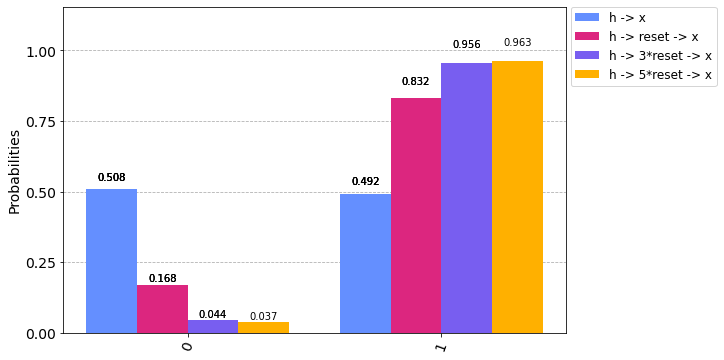

In [33]:
counts1 = job1q_0.result().get_counts()

legend_1q = ['h -> x', 'h -> reset -> x', 'h -> 3*reset -> x', 'h -> 5*reset -> x' ]
plot_histogram(counts1, legend=legend_1q, figsize=(9, 6))

### Multi-qubit reset experiment

The next experiment tests multi-qubit circuits. A complex circuit is considered with the possibility of multiple `reset` instructions in the middle. The expected result is given by the Aer qasm simulator (it can also be verified analytically). 

Without any `reset` instructions, we expect a unifrom distribution across 4 of the computational basis states ($|000\rangle$, $|001\rangle$, $|010\rangle$, $|011\rangle$). With `reset` added, we expect nearly all counts in the $|010\rangle$ state.

Once again, we run the circuit with 0, 1, and 3 `reset` instructions. We see an improvement for 1 reset and further improvement for 3 resets.

<div class="alert alert-block alert-info">
**Note:**   

The `reset` operation can be time intensive, so when working with multiple qubits it is important to be careful how `reset` instructions are done.

The backend will attempt to merge resets following standard commutation rules. However, if you attempt many resets on each individual qubit and they cannot be merged, it may lead to some states being favored as much of the qubit's T1 time is being used up. If you see results tending towards a single state as the number of resets increases, consider reducing the number of resets or performing the resets adjacent to one another. 
</div>

In [34]:
def multiq_custom_circ(n_resets):
    """Multi-qubit circuit on qubits 0, 1, 2 with ``n_resets`` reset instructions used."""
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.reset([0]*n_resets)
    qc.cx(0, 2)
    qc.reset([1]*n_resets)
    qc.x(1)
    qc.measure(range(2), range(2))
    return qc

In [35]:
multiq_circs = [multiq_custom_circ(0), multiq_custom_circ(1), multiq_custom_circ(3)]

In [36]:
# verify expected output
from qiskit import Aer
job_multiq_sim = execute(multiq_circs, 
                         backend=Aer.get_backend('qasm_simulator'))
counts_multiq_sim = job_multiq_sim.result().get_counts()
print("No reset sim counts, custom circ: ", counts_multiq_sim[0])
print("1 Reset sim counts, custom circ: ", counts_multiq_sim[1])

No reset sim counts, custom circ:  {'000': 241, '001': 258, '010': 279, '011': 246}
1 Reset sim counts, custom circ:  {'010': 1024}


In [37]:
job_multiq = execute(multiq_circs, backend)
job_monitor(job_multiq)

Job Status: job has successfully run


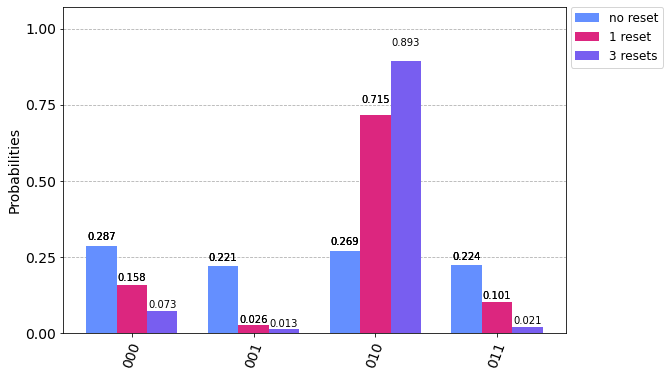

In [39]:
counts_multiq = job_multiq.result().get_counts()
legend_multiq = ['no reset', '1 reset', '3 resets']
plot_histogram(counts_multiq, legend=legend_multiq, figsize=(9, 6))

## Repetition delay and removing qubit initialization at the start of programs

This section covers two new features: Setting the repetition delay, and removing qubit initialization at the start of circuits. 

The repetition delay defines the delay time between circuit executions. For instance, if you run a job with 5 circuits, the repetition delay (`rep_delay` for short) defines how long the backend is idle for between the conclusion of one circuit and start of the next. This parameter provides finer grained control over the execution of your quantum circuits on IBM Quantum systems.

Shortening `rep_delay` can reduce execution time, and therefore reduce the sensitivity of your experiment to long term drifts in hardware parameter variations. However, setting too short a time may yield poorly initialized qubits.

With the smaller `rep_delay`, users may prefer to initialize circuits themselves via the `reset` instruction introduced above. For this reason, we have added a flag `init_qubits` which determines whether the default backend initialization sequence will be inserted. This allows users to work with "dirty qubits" and perform experiments with non-initialized states.

<div class="alert alert-block alert-info">

    
**Note:** If `init_qubits` is set to false and you want qubits to start in the ground state, you must insert resets at the start of your circuit. Otherwise, qubits will begin with their state from the previous shot (after undergoing some thermalization process for the interval between shots as set by `rep_delay`). Note that the first shot of the first circuit may still be in the thermal ground state due to a longer delay existing during the loading of your job to hardware.
</div>

In order to use `rep_delay`, we must check if the backend supports it. This is controlled by a flag in the backend configuration `dynamic_reprate_enabled`.

In [41]:
config.dynamic_reprate_enabled

True

Since dynamic rep rates are enabled on this device, we can proceed with specifying the delay time.

The backend specifies an allowed range of delay times, given by `rep_delay_range`. Having a continuous range provides users with fine-grained control of the delays. A default is also returned by the backend as `default_rep_delay`.

In [42]:
print(f"Range of delay times: {config.rep_delay_range}s")
print(f"Default delay time: {config.default_rep_delay}s")

Range of delay times: [0.0, 0.0005]s
Default delay time: 0.00045999999999999996s


We conduct a simple experiment to demonstrate the effect of `rep_delay` as follows:

1. Turn off qubit initialization using `init_qubits=False`.
2. Set `rep_delay` to something small (we use `rep_delay=0.005e-6 s`). 
3. Define a `dirty_q_circ()` method which puts the qubits in an unpredictable state.
4. Run the dirty circuit and then run some known circuit with a defined result.

The dirty circuit puts the qubits in an unknown state and then, since `rep_delay` is small and qubits are not initialized, we get an unpredictable (and often bad) result for our known circuit.

We "fix" this by modifying the known circuit to add some number of resets to the front of the circuit, thus initializing our qubits manually.

The circuits we run are `(some number of resets), measure` and `x, (some number of resets), measure`.

When no resets are inserted, we see a poor result in each case. However, with resets inserted we observe results closer to what we expect (all `0`'s for the `measure` and all `1`'s for the `x, measure`).

In [49]:
def dirty_q_circ():
    """Circuit to give bad qubit initialization."""
    # does random x rotation
    qc = QuantumCircuit(1, 1)
    theta = np.random.uniform(0, 2*np.pi)
    qc.rx(theta, 0)
    qc.measure(0, 0)
    return qc

def reset_x_circ(n_resets):
    """Reset, x circuit."""
    qc = QuantumCircuit(1, 1)
    for _ in range(n_resets):
        qc.reset(0)
    qc.x(0)
    qc.measure(0, 0)
    return qc

def reset_meas_circ(n_resets):
    """Reset, measure circuit."""
    qc = QuantumCircuit(1, 1)
    for _ in range(n_resets):
        qc.reset(0)
    qc.measure(0, 0)
    return qc

In [44]:
circs_no_init = [dirty_q_circ(), reset_meas_circ(0),  # 1
                 dirty_q_circ(), reset_x_circ(0),  # 3
                 dirty_q_circ(), reset_meas_circ(1),  # 5
                 dirty_q_circ(), reset_x_circ(1),  # 7
                 dirty_q_circ(), reset_meas_circ(3),  # 9
                 dirty_q_circ(), reset_x_circ(3)] # 11

`rep_delay` can be specified in `execute()` or `assemble()`. We choose `assemble()` so that we can print and verify our `rep_delay` in the `qobj.config`. Also note that `init_qubits=False`.

In [50]:
job_no_init = execute(circs_no_init, backend, init_qubits=False, optimization_level=0, rep_delay=0.005e-6)
job_monitor(job_no_init)

Job Status: job has successfully run


Like `rep_delay`, `init_qubits` can be set in `execute()` or `assemble()`.

In [51]:
counts_no_init = job_no_init.result().get_counts()
legend_no_init = ['0 resets', '1 reset', '3 resets']

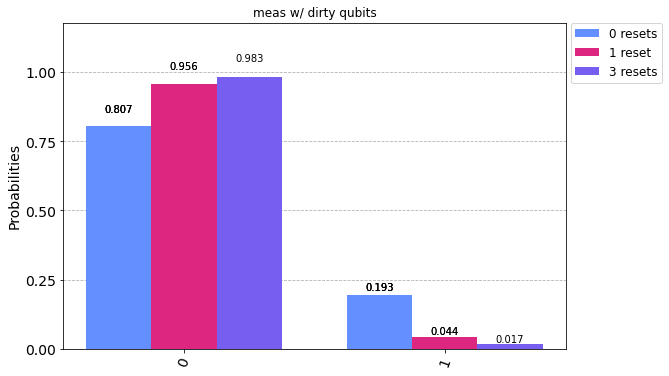

In [53]:
plot_histogram([counts_no_init[1], counts_no_init[5], counts_no_init[9]], 
                legend=legend_no_init, title='meas w/ dirty qubits', figsize=(9,6))

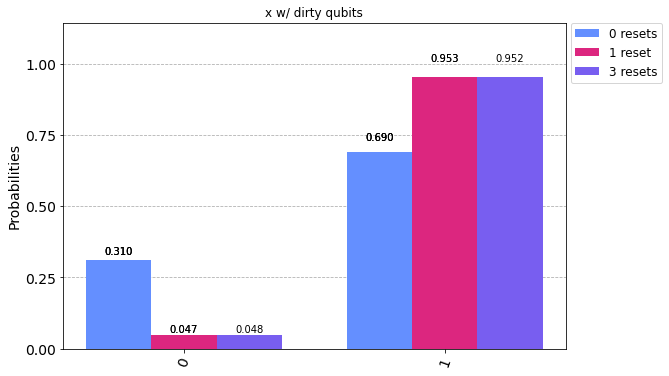

In [54]:
plot_histogram([counts_no_init[3], counts_no_init[7], counts_no_init[11]], 
                legend=legend_no_init, title='x w/ dirty qubits', figsize=(9,6))

Next, we consider how measurement fidelity varies with `rep_delay` when we add a `reset` at the beginning versus when we don't.

We replace `dirty_q_circ()` with an `x` gate as this is as far as we can get from $|0>$. We then run either `measure` or `reset, measure`. The `rep_delay` is varied from `0.005-350 us`, with 10 data points (you can run more, but it will take longer). 

Qubit initialization is again turned off. 

With a `reset`, the measurement fidelity is above 90% for all `rep_delay`s (the fidelity here is defined by the probability of measuring a `0`). However, without the `reset`, the fidelity begins low and steadily rises as `rep_delay` increases. This is because increasing `rep_delay` gives the qubit more time to cool back to its ground state.

In [56]:
def x_circ():
    qc = QuantumCircuit(1, 1)
    qc.x(0)
    qc.measure(0, 0)
    return qc

circs_no_reset = [x_circ(), reset_meas_circ(0)]
circs_reset = [x_circ(), reset_meas_circ(1)]
circs_no_reset = qiskit.transpile(circs_no_reset, backend=backend, optimization_level=0)
circs_reset = qiskit.transpile(circs_reset, backend=backend, optimization_level=0)

We have used `optimization_level=0` to avoid the `RemoveResetInZeroState` optimization pass from Qiskit (see [here](/api/qiskit/qiskit.transpiler.passes.RemoveResetInZeroState)). There is an open Qiskit issue discussing how best to align this pass with the new `reset` capabilities (see [here](https://github.com/Qiskit/qiskit-terra/issues/5127)).

In [57]:
# NOTE: If you run into an issue running more than 5 concurrent jobs, simply split up the loop.
no_reset_jobs = []
reset_jobs = []
rep_delays = np.linspace(0.005e-6, 350e-6, 10)  # rep delays to use in sec
print(f"rep_delays (us): {rep_delays}s")

for rep_delay in rep_delays:
    qobj_no_reset = assemble(circs_no_reset, backend, init_qubits=False, optimization_level=0, rep_delay=rep_delay)
    qobj_reset = assemble(circs_reset, backend, init_qubits=False, optimization_level=0, rep_delay=rep_delay)
    job_no_reset = backend.run(qobj_no_reset)
    job_reset = backend.run(qobj_reset)
    no_reset_jobs.append(job_no_reset)
    reset_jobs.append(job_reset)

rep_delays (us): [5.00000000e-09 3.88933333e-05 7.77816667e-05 1.16670000e-04
 1.55558333e-04 1.94446667e-04 2.33335000e-04 2.72223333e-04
 3.11111667e-04 3.50000000e-04]s


In [58]:
def prob0(counts):
    """Probability of 0 from a counts dict of the form {'0': int, '1': int}."""
    zero_counts = counts.get('0', 0)
    total_counts = zero_counts + counts.get('1', 0)
    return zero_counts / total_counts

In [59]:
# this could take few minutes
no_reset_counts = [no_reset_jobs[i].result().get_counts()[1] for i in range(10)]
reset_counts = [reset_jobs[i].result().get_counts()[1] for i in range(10)]

no_reset_prob0 = [prob0(counts) for counts in no_reset_counts]
reset_prob0 = [prob0(counts) for counts in reset_counts]

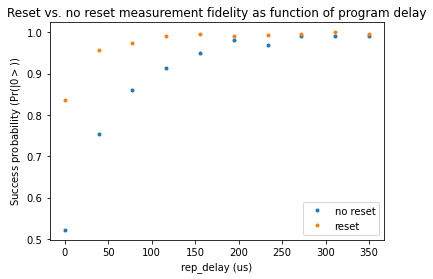

In [60]:
plt.plot(rep_delays*1e6, no_reset_prob0, '.', label='no reset')
plt.plot(rep_delays*1e6, reset_prob0, '.', label='reset')
plt.legend()
plt.xlabel('rep_delay (us)')
plt.ylabel('Success probability ($\Pr(|0>)$)')
plt.title('Reset vs. no reset measurement fidelity as function of program delay')
plt.show()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:
%qiskit_copyright